In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from models import Classifier, WeightedMSE, FlatLoss
from utils import Metrics, find_threshold, DataSet, Logger
from matplotlib.cm import get_cmap
np.random.seed(42)

# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ (with $ a = \frac{1}{4} $ and $ b = \frac{1}{2} $ ) using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but slightly different for signal and background.

In [2]:
n_s = int(5e4)
n_b = int(5e4)
n_s_gauss_frac = 0.8

a = 1/4 
b = 1/2

u = np.random.uniform(0,1,n_s)
u_ = np.random.uniform(0,1,n_b)

m_b = - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.5,0.1,size=int(n_s_gauss_frac*n_s))])
m_t = -b/(a) + np.sqrt((b-a)**2 + 2*a*u_)/(a)
m_t.sort()

x_b,y_b  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T
x_s,y_s  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_s).T
x_t,y_t  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T


z_b = np.random.normal(0,1,n_b)
z_s = np.random.normal(0.5,1,n_s)
z_t = np.random.normal(0,1,n_b)

In [3]:
x = np.concatenate([np.stack([m_s,m_s**2+2*m_s,x_s,y_s,z_s],axis=1),
                   np.stack([m_b,m_b**2+2*m_b,x_b,y_b,z_b],axis=1)])

y = np.concatenate([np.zeros(m_s.size),np.ones(m_b.size)])

x_test = np.stack([m_t,m_t**2+2*m_t,x_t,y_t,z_t],axis=1) 

# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]


traindataset = DataSet(x_train[::,1:].astype('float32'),y_train.astype('int32'),x_train[::,0].astype('float32'))
valdataset = DataSet(x_val[::,1:].astype('float32'),y_val.astype('int32'),x_val[::,0].astype('float32'))
testTensor= torch.from_numpy(x_test[::,1:]).float()

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('device used in training:', device)

device used in training: cpu


In [5]:
my_cmap = get_cmap('viridis')
my_cmap.set_bad(my_cmap.colors[0])

params = {'epochs'       : 200,
          'interval'     : 100,
          'batch_size'   : 4096,
          'shuffle'      : True,
          'num_workers'  : 6,
          'drop_last'    : False,
          'device'       : device,
          'pass_x_biased': True,
         }

logger = Logger("./log/logL2.txt",overwrite=True)

Entering Training...
Epoch:0100/0200  (33.1 s)
 Train: loss:0.1618, acc:77% || Val: loss: 0.1624, acc:78%, R50: 11.2087, 1/JSD: 3.7598
Epoch:0200/0200  (68.4 s)
 Train: loss:0.1607, acc:79% || Val: loss: 0.1599, acc:78%, R50: 11.4777, 1/JSD: 3.9537


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


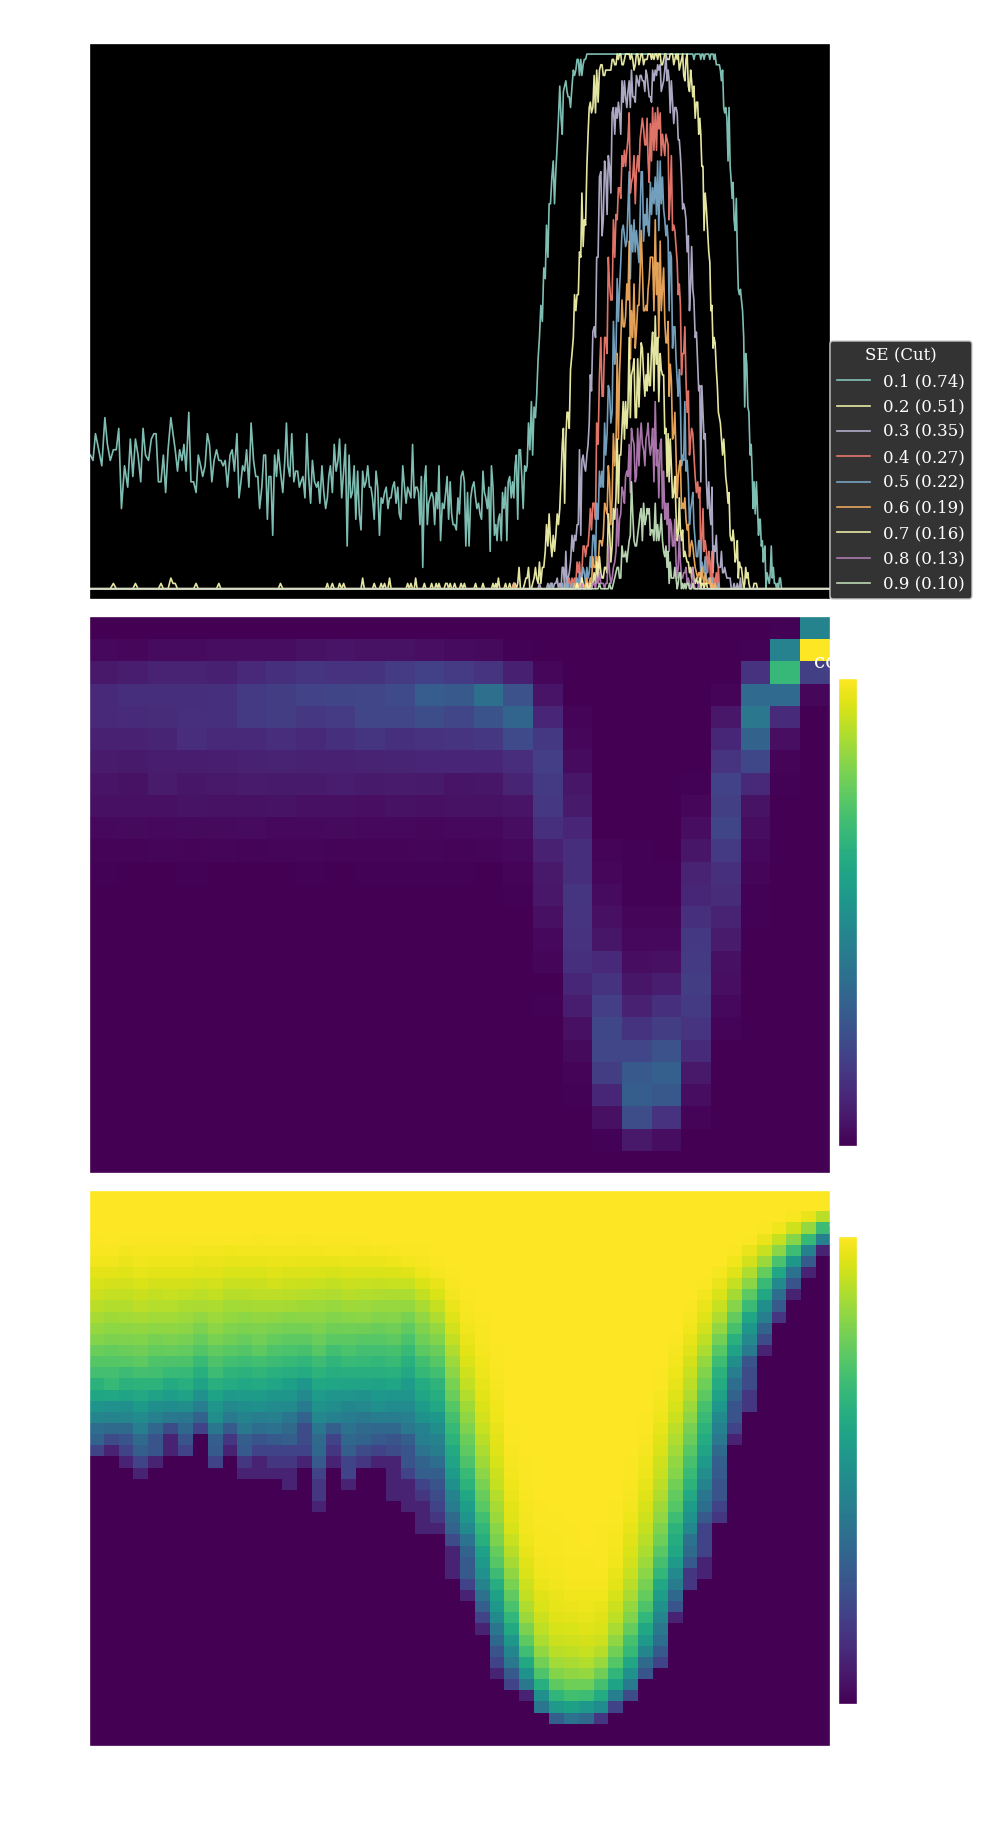

Entering Training...
Epoch:0100/0200  (42.5 s)
 Train: loss:0.1089, acc:78% || Val: loss: 0.1673, acc:77%, R50: 11.0728, 1/JSD: 4.1713
Epoch:0200/0200  (82.3 s)
 Train: loss:0.1088, acc:78% || Val: loss: 0.1612, acc:78%, R50: 11.2087, 1/JSD: 3.8629


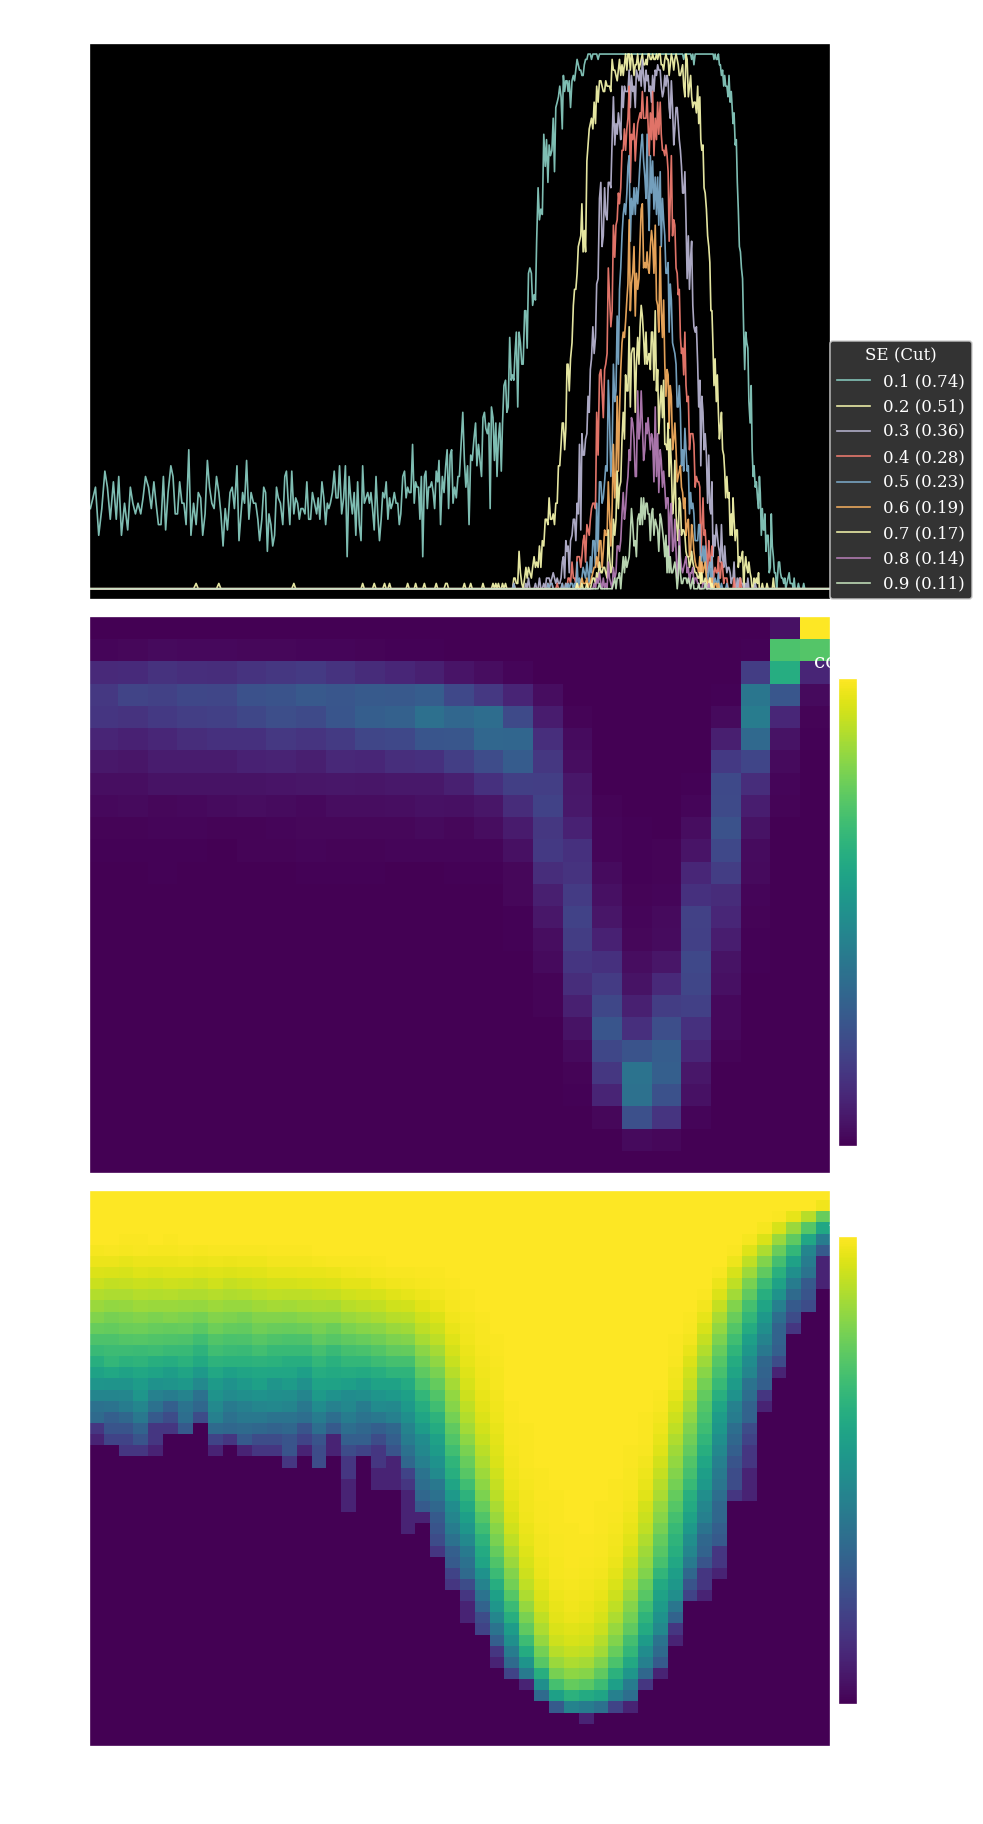

Entering Training...
Epoch:0100/0200  (38.7 s)
 Train: loss:0.0854, acc:78% || Val: loss: 0.1710, acc:77%, R50: 10.7873, 1/JSD: 4.3113
Epoch:0200/0200  (77.4 s)
 Train: loss:0.0840, acc:77% || Val: loss: 0.1625, acc:78%, R50: 11.1837, 1/JSD: 3.8617


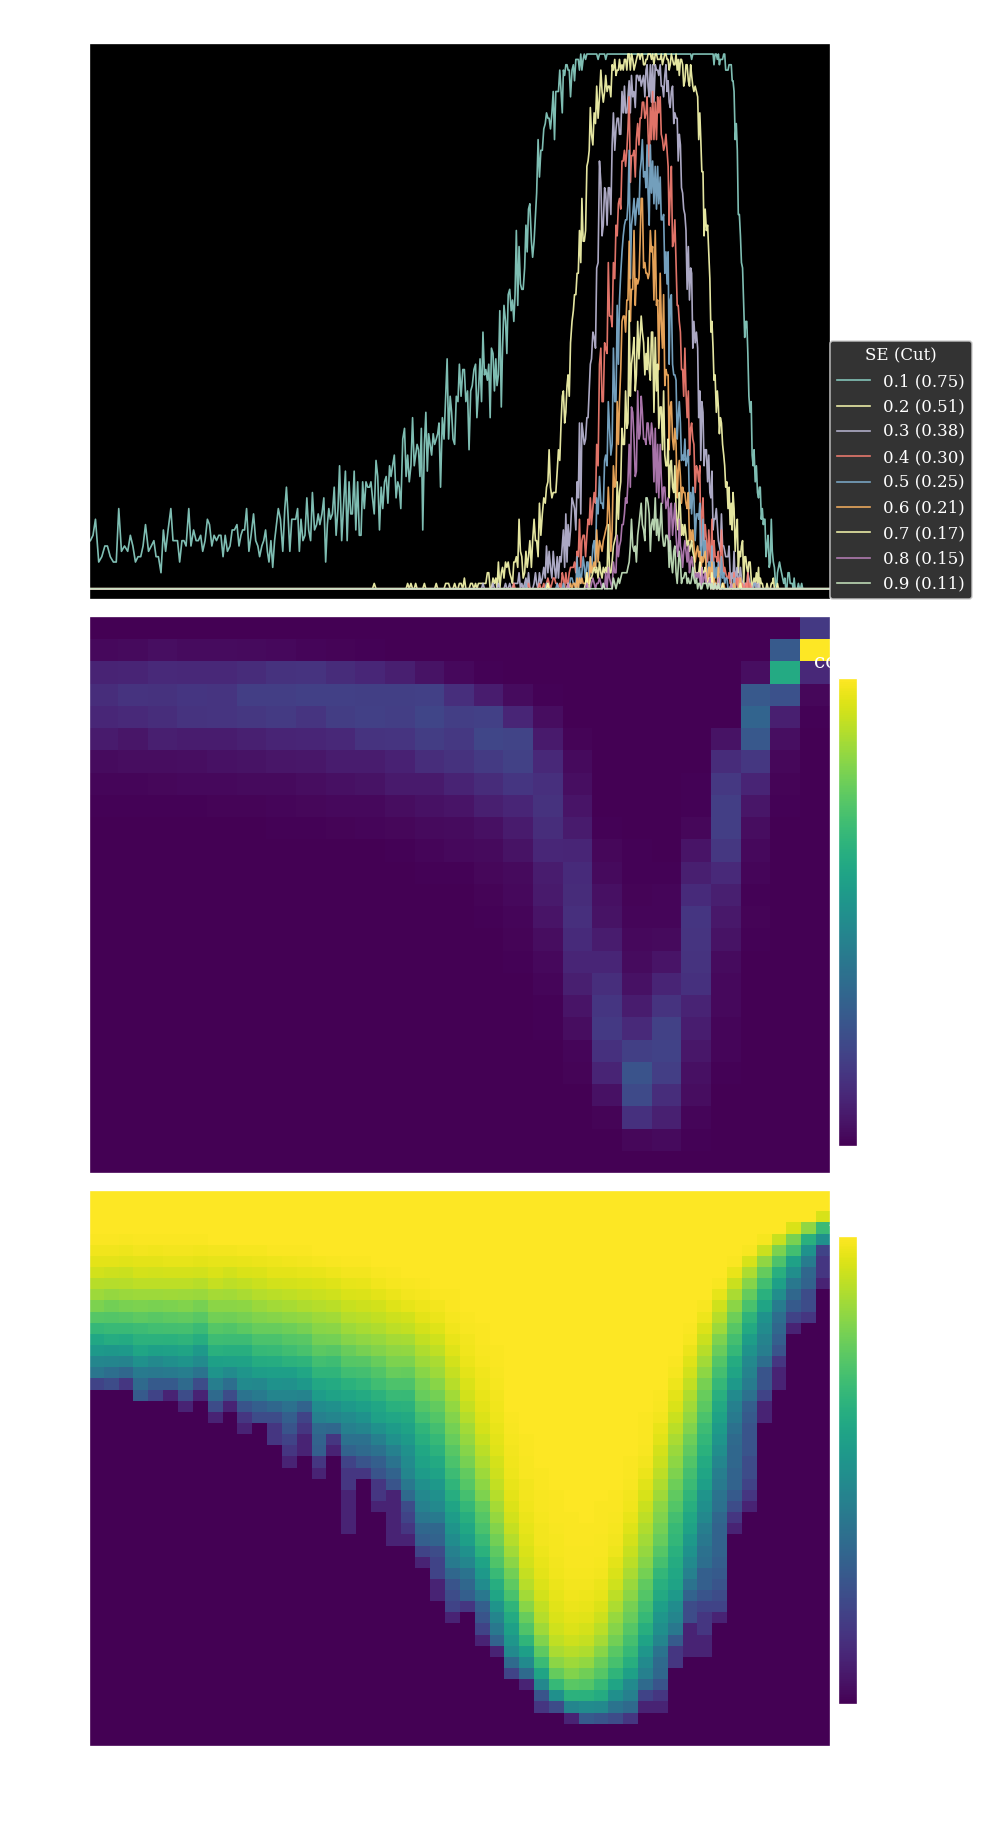

Entering Training...
Epoch:0100/0200  (46.2 s)
 Train: loss:0.0681, acc:70% || Val: loss: 0.2050, acc:69%, R50: 5.5702, 1/JSD: 12.0496
Epoch:0200/0200  (84.8 s)
 Train: loss:0.0588, acc:78% || Val: loss: 0.1726, acc:77%, R50: 10.6051, 1/JSD: 4.7133


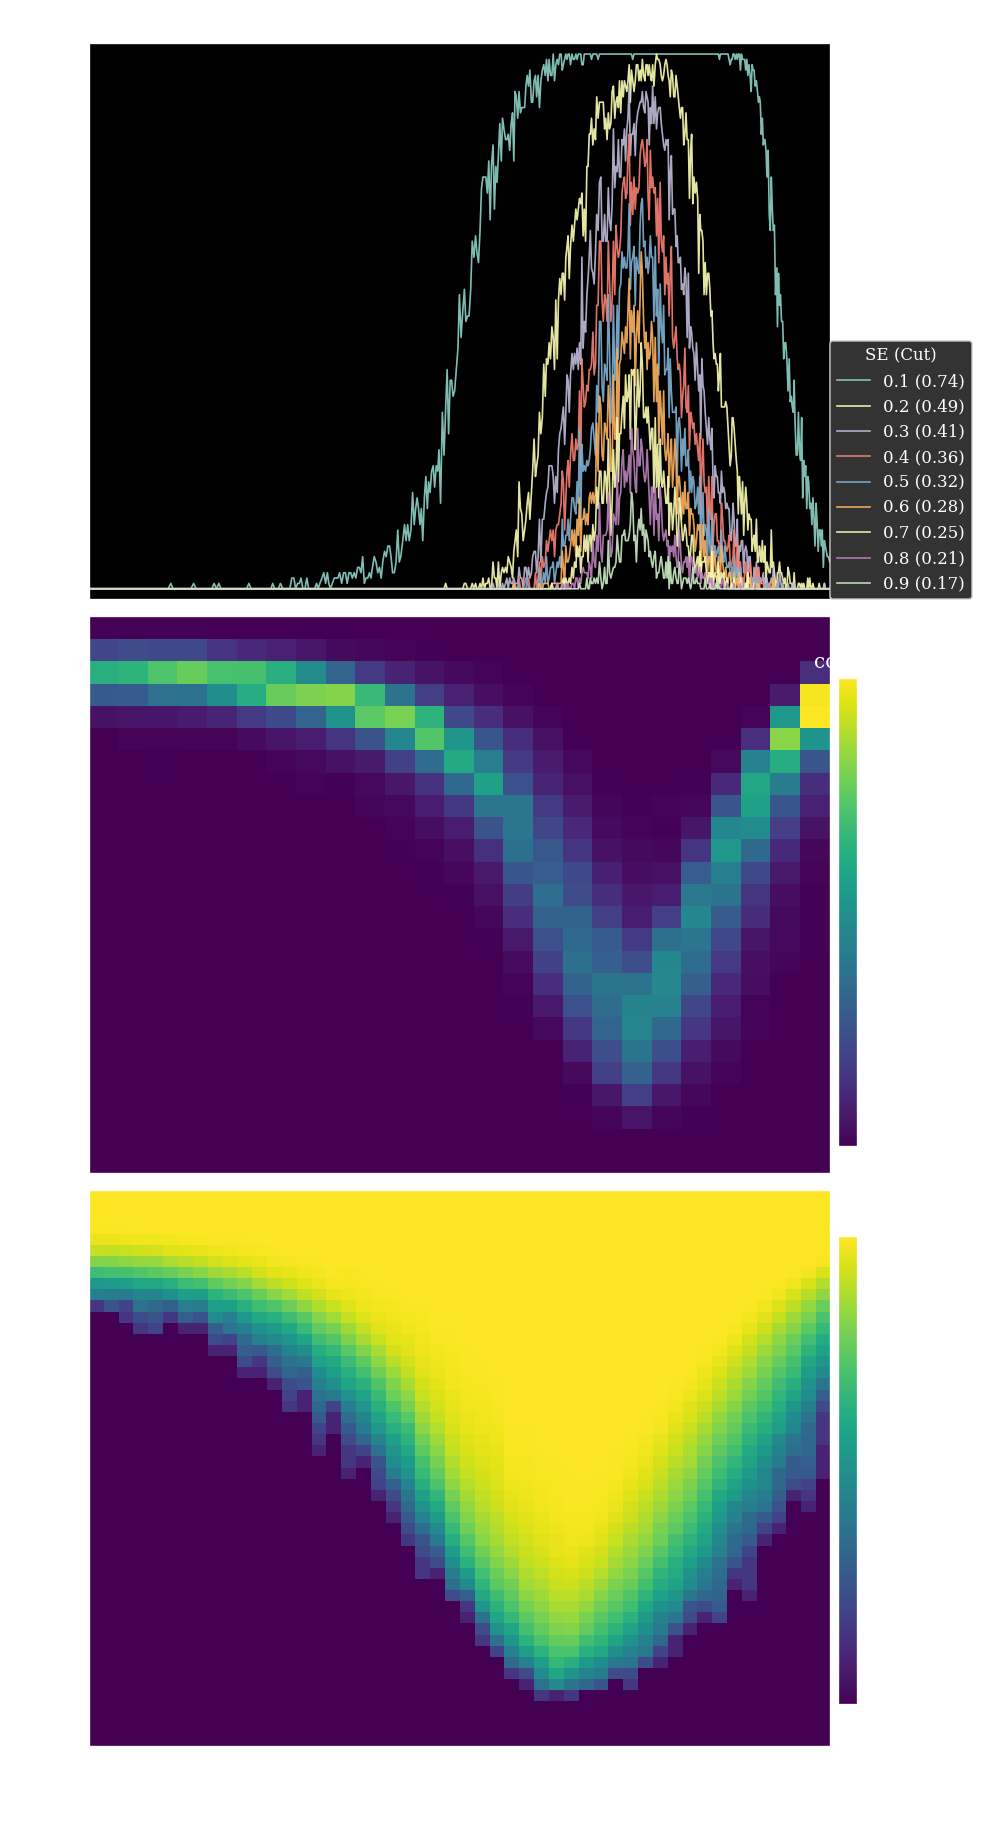

Entering Training...
Epoch:0100/0200  (39.6 s)
 Train: loss:0.0516, acc:69% || Val: loss: 0.2072, acc:68%, R50: 5.4024, 1/JSD: 12.0520
Epoch:0200/0200  (79.3 s)
 Train: loss:0.0446, acc:76% || Val: loss: 0.1764, acc:76%, R50: 9.9337, 1/JSD: 5.0673


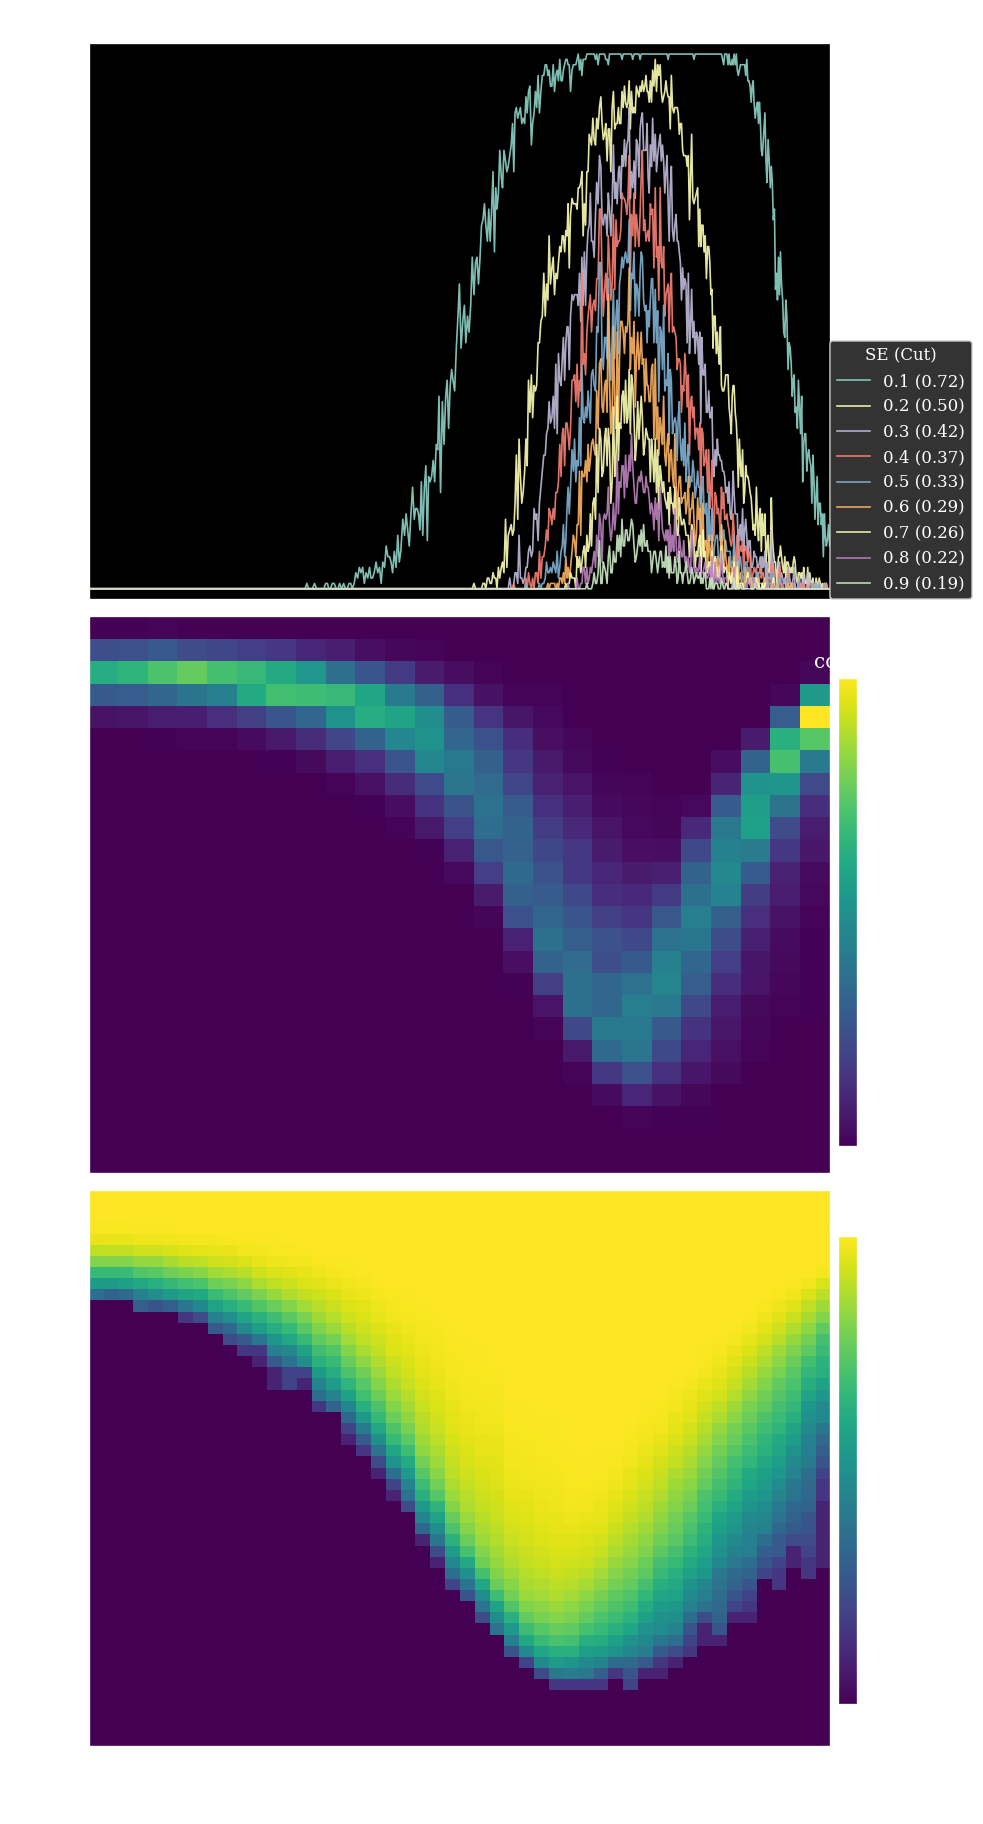

Entering Training...
Epoch:0100/0200  (42.3 s)
 Train: loss:0.0362, acc:68% || Val: loss: 0.2174, acc:66%, R50: 4.4596, 1/JSD: 6.6610
Epoch:0200/0200  (82.0 s)
 Train: loss:0.0334, acc:72% || Val: loss: 0.1971, acc:72%, R50: 6.5342, 1/JSD: 10.0975


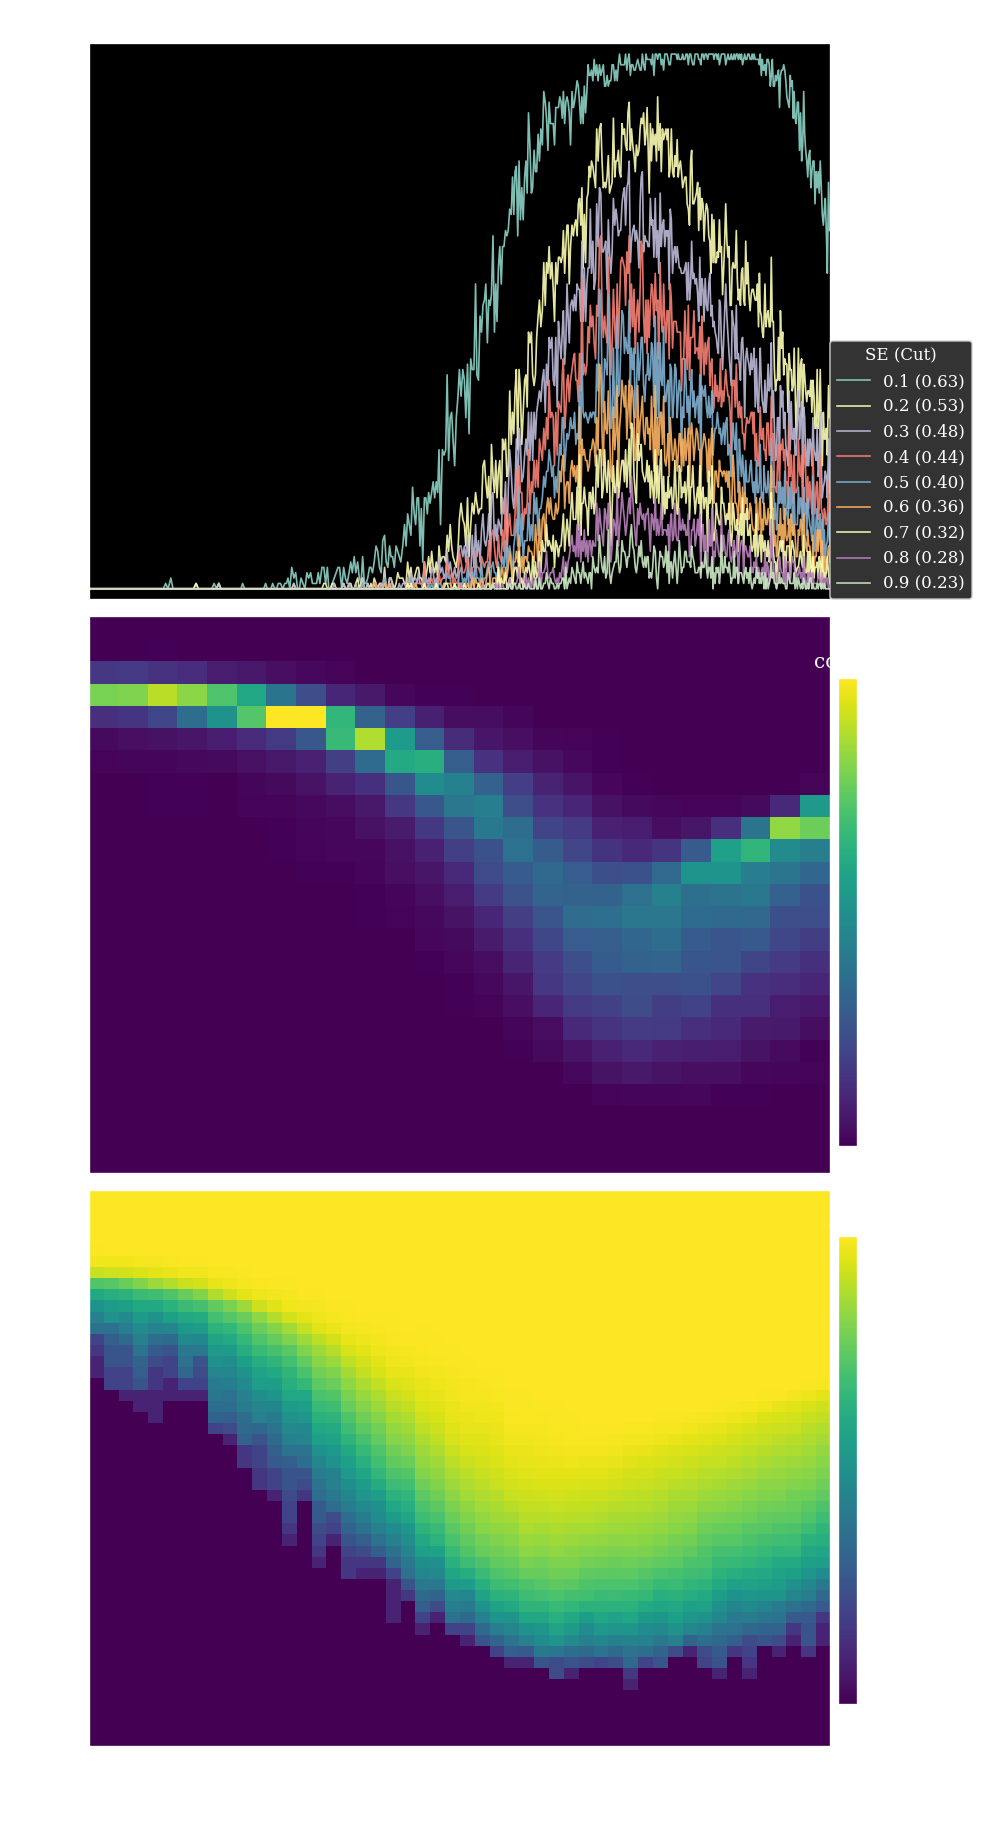

Entering Training...
Epoch:0100/0200  (45.8 s)
 Train: loss:0.0208, acc:66% || Val: loss: 0.2258, acc:65%, R50: 4.1076, 1/JSD: 6.5531
Epoch:0200/0200  (87.5 s)
 Train: loss:0.0194, acc:68% || Val: loss: 0.2101, acc:67%, R50: 4.9693, 1/JSD: 7.2260


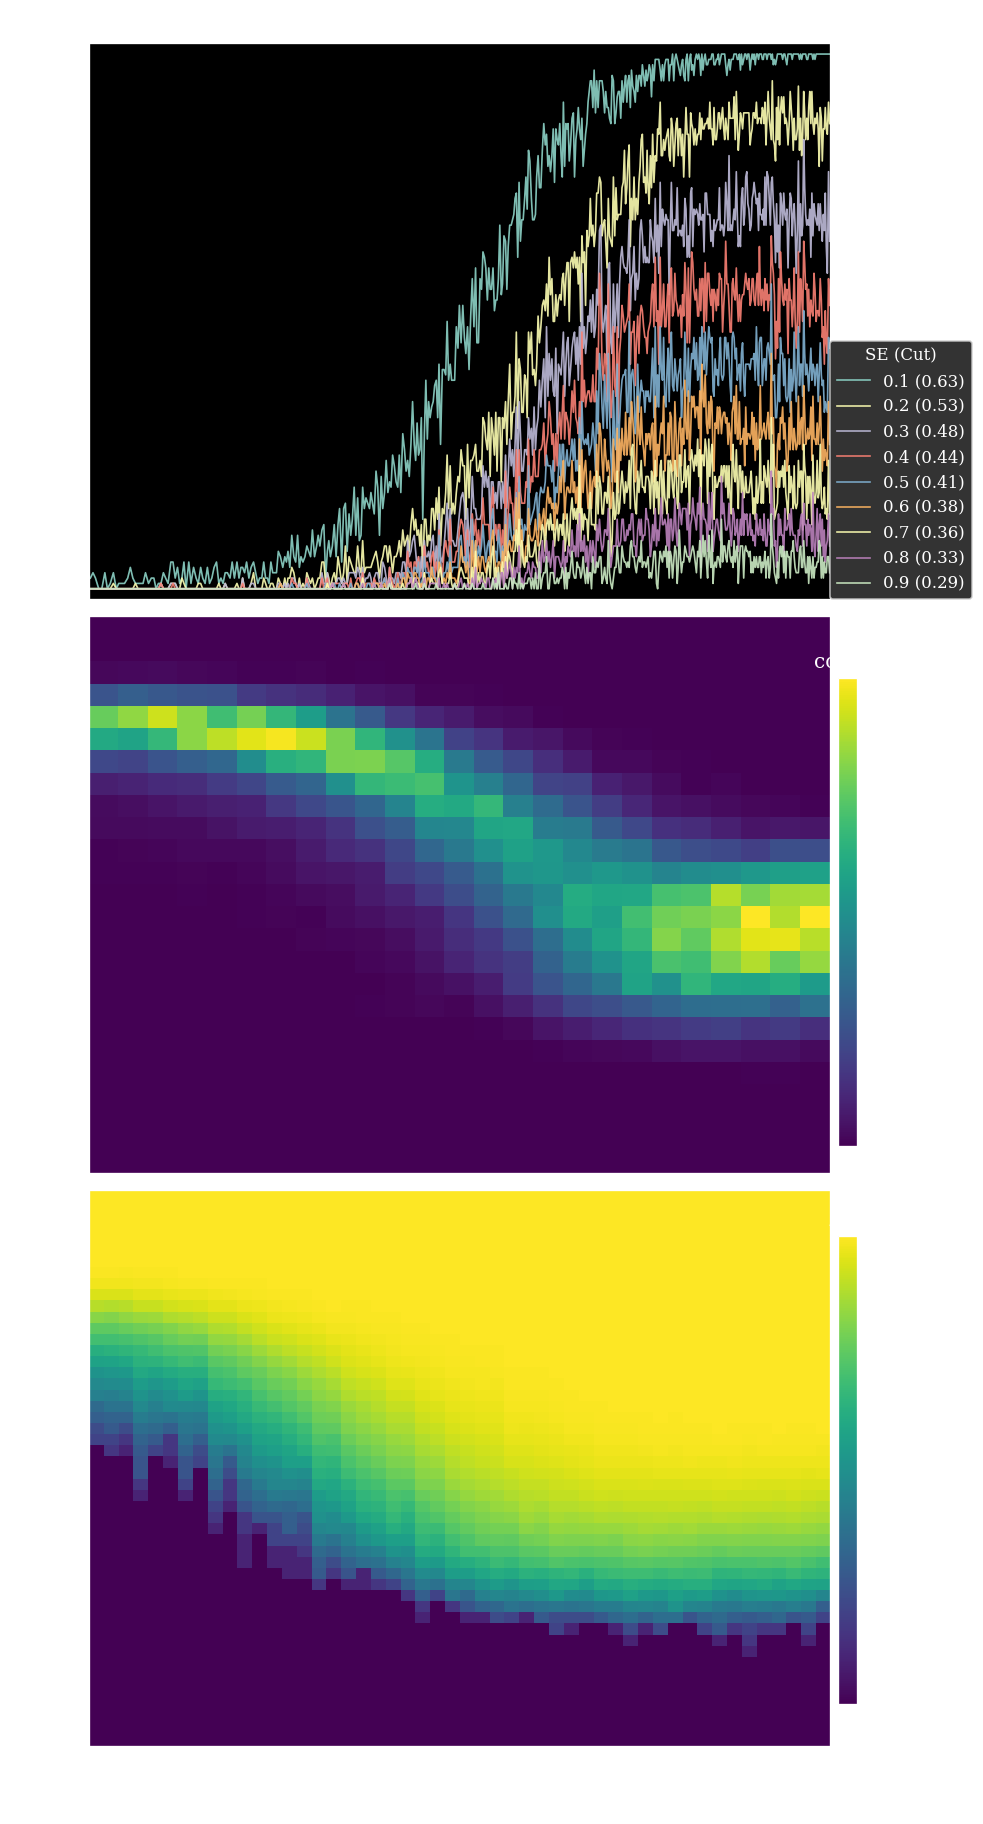

Entering Training...
Epoch:0100/0200  (39.8 s)
 Train: loss:0.0149, acc:64% || Val: loss: 0.2378, acc:65%, R50: 3.6653, 1/JSD: 5.8916
Epoch:0200/0200  (79.7 s)
 Train: loss:0.0142, acc:65% || Val: loss: 0.2233, acc:66%, R50: 4.1346, 1/JSD: 6.3404


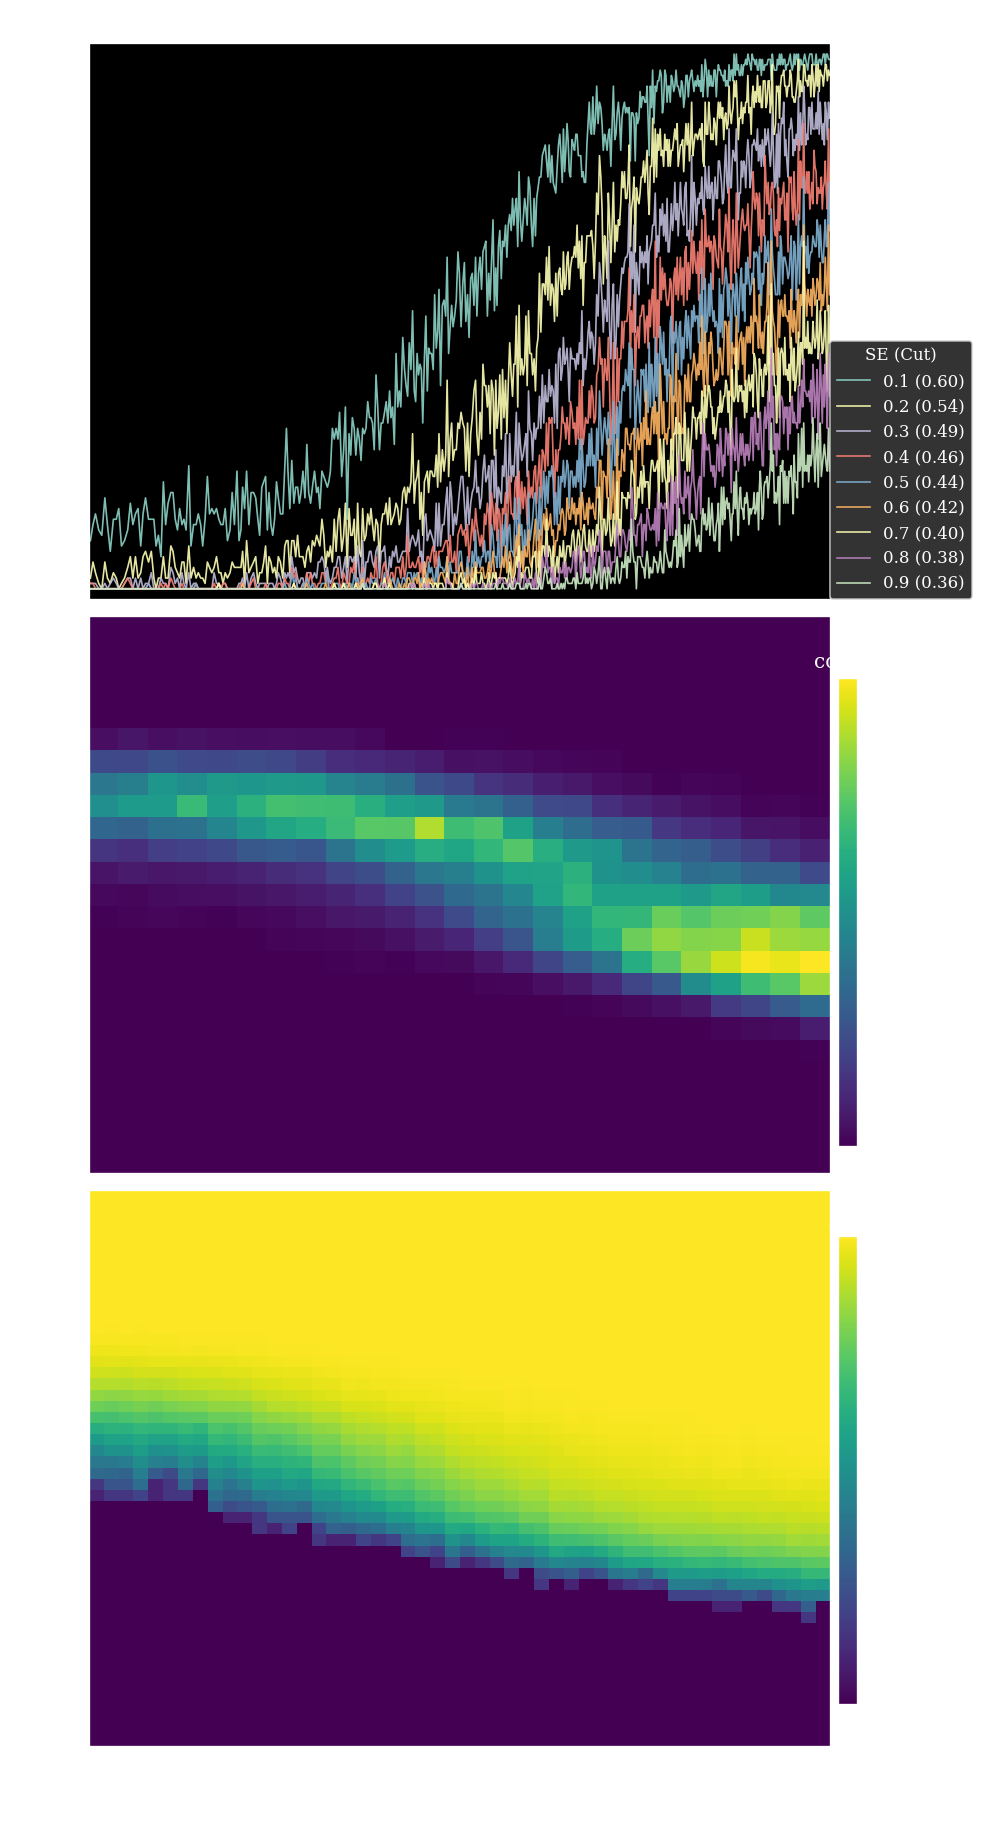

Entering Training...
Epoch:0100/0200  (46.9 s)
 Train: loss:0.0117, acc:61% || Val: loss: 0.2455, acc:61%, R50: 3.5030, 1/JSD: 116.2779
Epoch:0200/0200  (86.0 s)
 Train: loss:0.0115, acc:62% || Val: loss: 0.2386, acc:63%, R50: 4.0447, 1/JSD: 17.8038


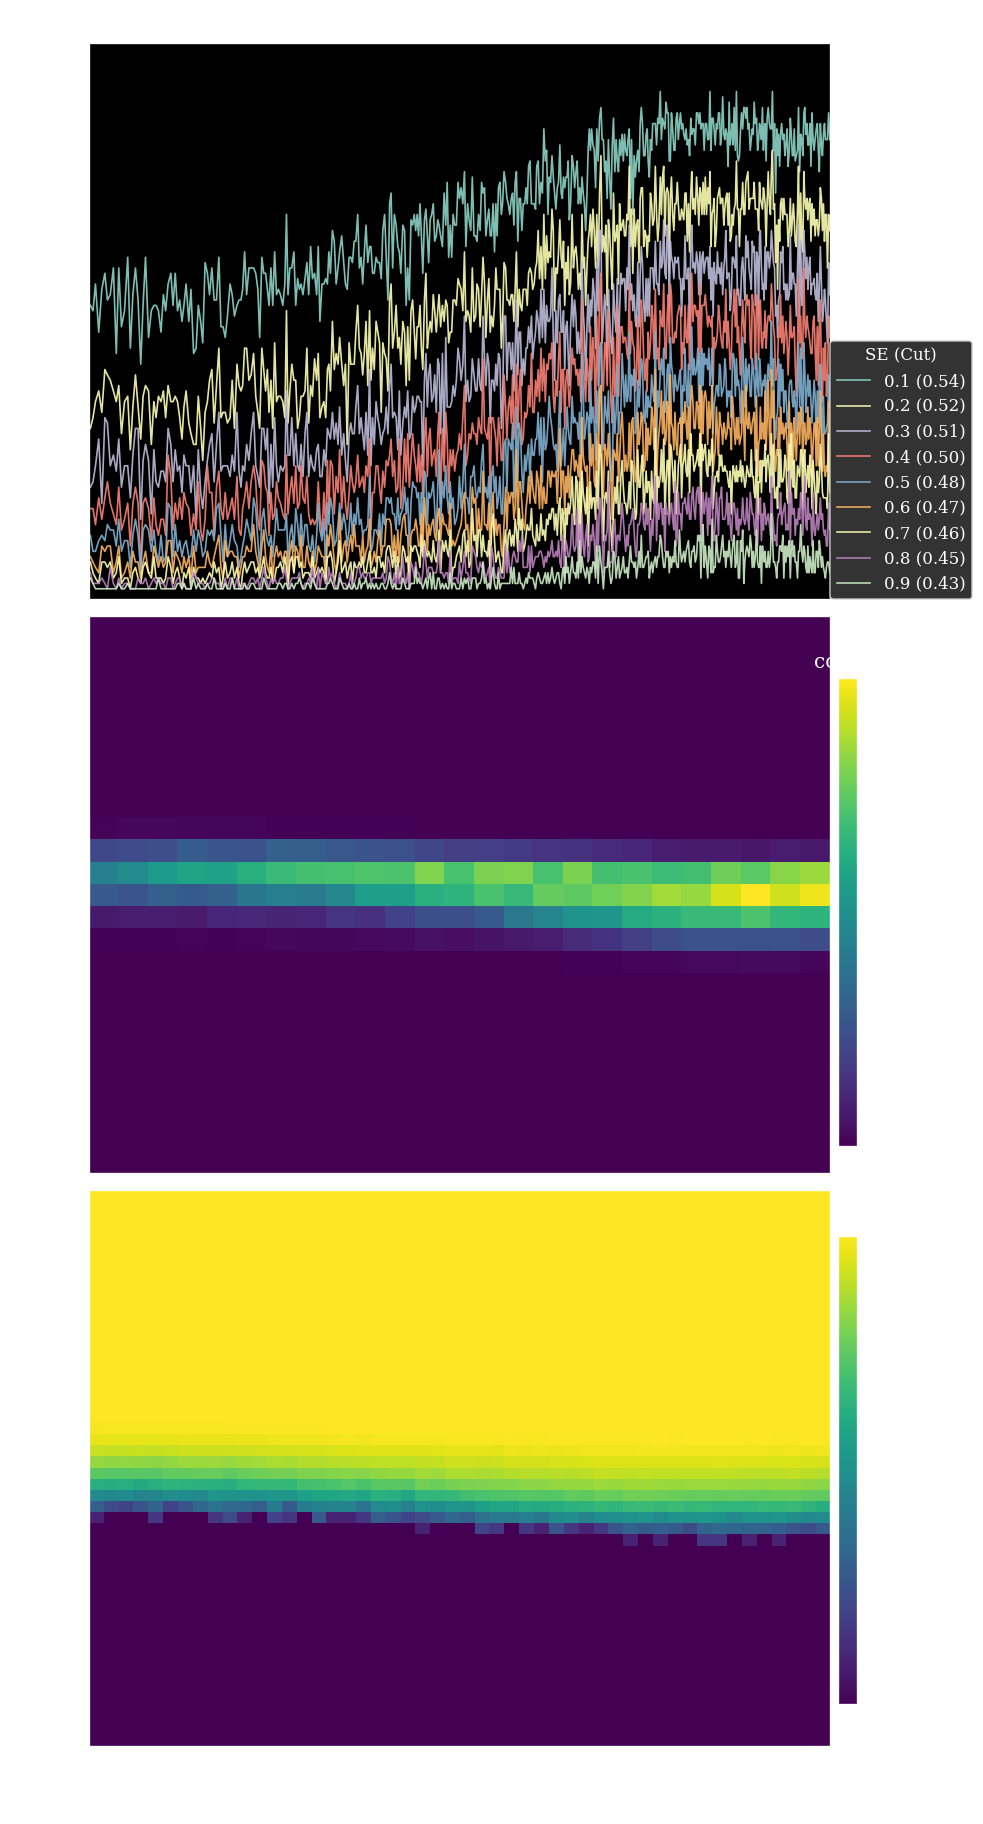

In [6]:
torch.manual_seed(69)
efficiencies = np.linspace(0.1,0.9,9)
for strength in [0,0.5,1,2,3,5,10,15,20]:
    frac = strength/(1+strength)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics(validation=True)
    model_legendre = Classifier(input_size=4)
    model_legendre.loss = FlatLoss(frac=frac,labels=y_train,bins=128,
                                   background_only=True,norm='L2',recalculate=False)
    model_legendre.fit(traindataset=traindataset,
                       valdataset=valdataset,
                       **params,
                       optimizer=torch.optim.SGD(model_legendre.parameters(),lr=1e-1,momentum=0.),
                       #scheduler=scheduler,
                       log = logger,
                       metrics=[metrics_train_legendre,metrics_val_legendre])
    
    validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(validation_predictions,(y_val==0),eff))
    
    
    scores = np.array(model_legendre(testTensor).tolist()).reshape(-1,100)
    m = m_t.reshape(-1,100).mean(axis=1)
    F_s = []
    for s in scores.reshape(50,-1):
        density = np.histogram(s,bins=50,range=(0,1))[0]
        F_s.append(np.cumsum(density)/density.sum())
    F_s = np.array(F_s).T
    fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True)
    for j,cut in enumerate(cuts):
        c = f"C{j}" if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
    ax1.set_ylim([-0.02,1.02])
    ax1.set_title("(strength: {:.02f}, acc: {:.02})".format(strength, metrics_val_legendre.accs[-1]),fontsize=17)
    ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

    _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",cmap='viridis',range=[[-1,1],[0,1]])
    cbaxes = fig.add_axes([0.86, 0.37, 0.02, 0.26]) 
    cb = plt.colorbar(h,ax=ax2,cax = cbaxes)
    cb.ax.set_title("counts")
    ax2.set_ylabel(r"$s$",fontsize=17)

    im = ax3.imshow(F_s,label="all",origin='lower',extent=[-1,1,0,1],aspect="auto",norm=LogNorm(),cmap=my_cmap)
    ax3.set_ylabel(r"$s$",fontsize=17)

    cbaxes = fig.add_axes([0.86, 0.06, 0.02, 0.26]) 
    cb = plt.colorbar(im,ax=ax3,cax = cbaxes)
    cb.ax.set_title(r"$F(s)$")
    ax3.set_xlabel(r"$m$",fontsize=19)

    fig.tight_layout(pad=0)
    plt.show()